In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
data = np.zeros((100,10))

#Label 1
data[0] = [1,1,1,1,1,1,1,1,1,1]
for i in range(49):
  data[1+i] = np.random.randint(2, 10, size=10)

#label -1
data[50] = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
for i in range(49):
  data[51+i] = np.random.randint(-10, -2, size=10)

labels = np.zeros((1,100))
labels[0, :50] = 1
labels[0, 50:] = -1

In [0]:
# N = Number of training samples, D = Sample dimension.
# data is a N*D matrix of the input dataset.
# lables is a N*1 vector of the true classification labels.
# W_arr is an array of weights matrices, in the order of computation.
# W is the product of all matrices in W_arr.
# W_norms_arr is an array of tensors representing the norms of the weight matrices.
# learning_rate = GD step size.
# n_iter = Number of optimization iterations.
def TrainNN(data, labels, W_arr, W, W_norms_arr, learning_rate, n_iter):
  # X is the placeholder for the input dataset.
  X = tf.placeholder(tf.float64, shape=data.shape)
  # Y is the placeholder for the true classification values.
  Y = tf.placeholder(tf.float64, shape=labels.shape)
  
  W_norm = tf.norm(W)
  
  # Below, we define the structure and computation of the NN using the placeholders,
  # during the optimization process the placeholders are assigned values (defined below as feed_data).
  
  # V is the computed output of the NN. Its length is the number of training samples.
  # When the NN has several layers, V holds the values of the intermediate steps.
  V = tf.matmul(W_arr[0], X) # V is the product of the input data and the weights of the first layer. Do we want to apply the normalization on the input data also??
    
  if len(W_arr) >= 2:
    for i in range(len(W_arr)):
      if i==0: # The first product was already computed above.
        continue
      # Computing the result of the current layer, that is:
      # V_i = W_i * relu(V_i-1)
      V = tf.matmul(W_arr[i], tf.nn.relu(V), transpose_a=True)
  
  # Computing the loss, the sum of losses of all training examples.
  loss = tf.reduce_sum(tf.log(1+tf.exp(-Y*V)))
  
  # Defining the gradient descent optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  train = optimizer.minimize(loss)

  # Initializing the tensorflow session.
  sess = tf.Session()
  init = tf.global_variables_initializer()
  sess.run(init)

  # This object places both the input dataset and the true labels on the placeholders.
  feed_data = {X: data, Y: labels}

  # Placeholders for results
  result_loss = []
  result_norm = []
  result_vectors = []
  result_W_norms_arr = np.zeros((len(W_norms_arr), n_iter))
  V_vector = []

  # Run n_iter steps of Gradient Descent optimization
  for i in range(n_iter):
    # Training iteration, Grad. Descent step.
    sess.run(train, feed_dict=feed_data)
    # Tracking loss values
    result_loss.append(sess.run(loss, feed_dict=feed_data))
    # Tracking the product of all matrices.
    result_vectors.append(sess.run(W, feed_dict=feed_data))
    # Tracking the norm of the product of all matrices.
    result_norm.append(sess.run(W_norm, feed_dict=feed_data))
    # Tracking the current output of the NN for all training samples.
#     V_vector.append(sess.run(V, feed_dict=feed_data))
    # Tracking norms of each layer
    for w_idx in range(len(W_norms_arr)):
      result_W_norms_arr[w_idx][i] = sess.run(W_norms_arr[w_idx], feed_dict=feed_data)

    if i%100 == 0:
      print '\r ' + str(i) + ' out of ' + str(n_iter),
  print
  return result_loss, result_norm, result_vectors, result_W_norms_arr, V_vector

In [0]:
def DrawGraphs(n_iter, result_loss, result_norm, result_vectors, result_W_norms_arr):
  t = list(range(n_iter))
  fig = plt.figure(figsize=(20,20))
  plot1 = fig.add_subplot(441)
  plot2 = fig.add_subplot(442)
  plot7 = fig.add_subplot(443)
  plot3 = fig.add_subplot(444)
  plot4 = fig.add_subplot(445)
  plot5 = fig.add_subplot(446)
  plot6 = fig.add_subplot(447)

  # Plotting normalized ||w(t)||
  normalized_result_norm = result_norm / result_norm[-1]
  plot1.set_ylabel('Normalized ||w(t)||')
  plot1.set_xlabel('t')
  plot1.semilogx(t, normalized_result_norm, color='blue')
  
  # Plotting the loss tracking
  plot2.set_ylabel('L(W(t))')
  plot2.set_xlabel('t')
  plot2.loglog(t, result_loss, color='blue')
  plot7.set_ylabel('L(W(t))')
  plot7.set_xlabel('t')
  plot7.semilogx(t, result_loss, color='blue')
  
  w_hat = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
  angle_gap = []
  margin_gap = []
  for w_t in result_vectors:
    w_t_tmp = w_t[0] # Outboxing

    # Calculating the angle gap
    angle_gap.append(
        1 - np.matmul(
            w_hat,
            np.transpose(w_t_tmp))/(np.linalg.norm(w_t_tmp)*np.linalg.norm(w_hat)))

    # Calculating margin gap
    min_xn_wt = np.amin(np.absolute(np.matmul(data, np.transpose(w_t_tmp))))
    margin_gap.append(
        (1/np.linalg.norm(w_hat)) - (min_xn_wt/np.linalg.norm(w_t_tmp)) )
  

  plot3.set_ylabel('Angle Gap')
  plot3.set_xlabel('t')
  plot3.semilogx(t, angle_gap, color='blue')
  
  plot4.set_ylabel('Angle Gap')
  plot4.set_xlabel('t')
  plot4.loglog(t, np.absolute(angle_gap), color='blue')
  
  # Plotting margin gap
  plot5.set_ylabel('Margin Gap')
  plot5.set_xlabel('t')
  plot5.semilogx(t, margin_gap, color='blue')
  
  plot6.set_ylabel('Margin Gap')
  plot6.set_xlabel('t')
  plot6.loglog(t, np.absolute(margin_gap), color='blue')
  
  for idx in range(len(result_W_norms_arr)):
    plot1 = fig.add_subplot(4, 4, 8+idx)
    plot1.semilogx(t, result_W_norms_arr[idx]/result_W_norms_arr[idx][-1], color='blue')
    plot1.set_ylabel('Normalized ||W'+str(idx+1)+'(t)||')
    plot1.set_xlabel('t')

 99900 out of 100000


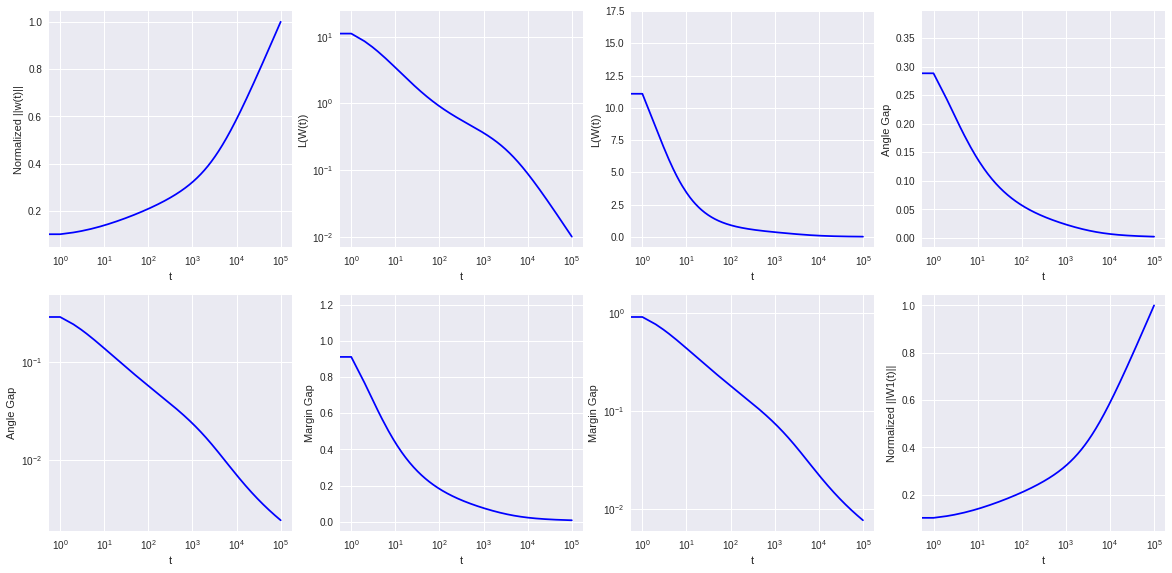

In [16]:
# Initialize the weights with a normal distribution to diversify the neurons behaviour.
W1 = tf.Variable(tf.truncated_normal([1,10], stddev=0.05,  dtype=tf.float64), dtype=tf.float64)

W1_norm = tf.norm(W1)
W_arr = [W1]

W_norm_arr = [W1_norm]

n_iter = 10**5
result_loss, result_norm, result_vectors, result_W_norms_arr, output_vector = TrainNN(np.transpose(data), labels, W_arr, W1, W_norm_arr, 0.0001, n_iter)
DrawGraphs(n_iter, result_loss, result_norm, result_vectors, result_W_norms_arr)

 99900 out of 100000


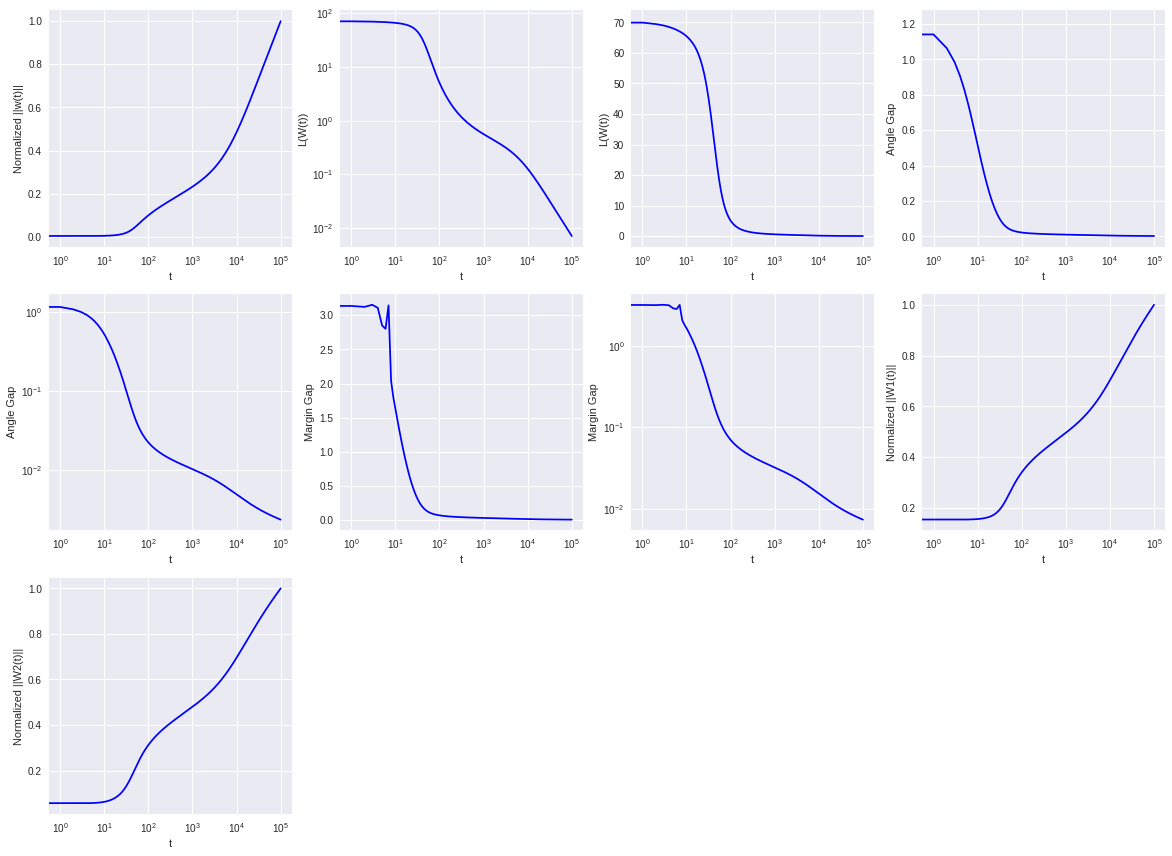

In [17]:
# Initialize the weights with a normal distribution to diversify the neurons behaviour
W1 = tf.Variable(tf.truncated_normal([4,10], stddev=0.05,  dtype=tf.float64),  dtype=tf.float64)
W2 = tf.Variable(tf.truncated_normal([4,1], stddev=0.05,  dtype=tf.float64),  dtype=tf.float64)

W = tf.matmul(W2, W1, transpose_a=True)

W_arr = [W1, W2]

W1_norm = tf.norm(W1)
W2_norm = tf.norm(W2)

W_norm_arr = [W1_norm, W2_norm]

n_iter = 10**5
result_loss, result_norm, result_vectors, result_W_norms_arr, output_vector = TrainNN(np.transpose(data), labels, W_arr, W, W_norm_arr, 0.0001, n_iter)
DrawGraphs(n_iter, result_loss, result_norm, result_vectors, result_W_norms_arr)

 999900 out of 1000000


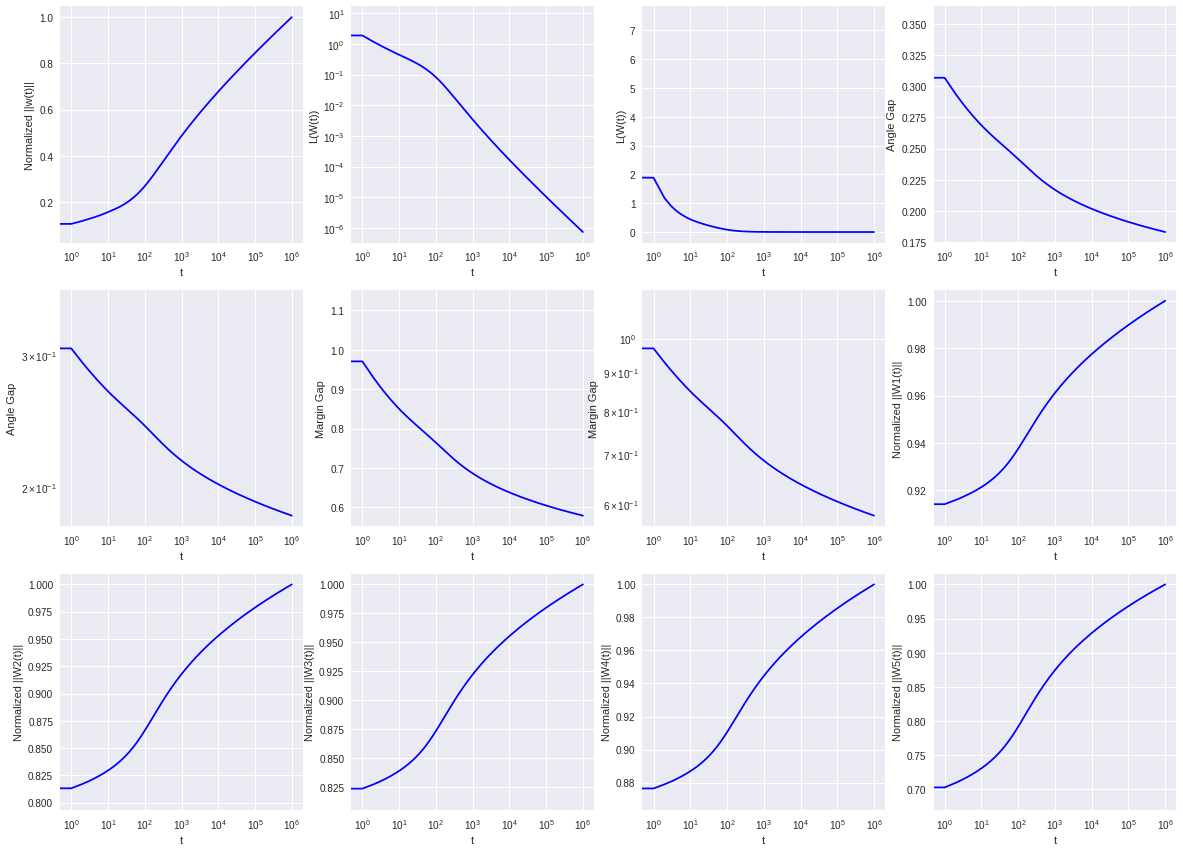

In [21]:
# Initialize the weights with a normal distribution to diversify the neurons behaviour
W1 = tf.Variable(tf.truncated_normal([4,10], stddev=0.6,  dtype=tf.float64),  dtype=tf.float64)
W2 = tf.Variable(tf.truncated_normal([4,4], stddev=0.6,  dtype=tf.float64),  dtype=tf.float64)
W3 = tf.Variable(tf.truncated_normal([4,4], stddev=0.6,  dtype=tf.float64),  dtype=tf.float64)
W4 = tf.Variable(tf.truncated_normal([4,4], stddev=0.6,  dtype=tf.float64),  dtype=tf.float64)
W5 = tf.Variable(tf.truncated_normal([4,1], stddev=0.6,  dtype=tf.float64),  dtype=tf.float64)

W = tf.matmul(W5, tf.matmul(W4, tf.matmul(W3, tf.matmul(W2, W1, transpose_a=True), transpose_a=True), transpose_a=True), transpose_a=True)

W_arr = [W1, W2, W3, W4, W5]

W1_norm = tf.norm(W1)
W2_norm = tf.norm(W2)
W3_norm = tf.norm(W3)
W4_norm = tf.norm(W4)
W5_norm = tf.norm(W5)

W_norm_arr = [W1_norm, W2_norm, W3_norm, W4_norm, W5_norm]

n_iter = 10**6
result_loss, result_norm, result_vectors, result_W_norms_arr, output_vector = TrainNN(np.transpose(data), labels, W_arr, W, W_norm_arr, 0.005, n_iter)
DrawGraphs(n_iter, result_loss, result_norm, result_vectors, result_W_norms_arr)